In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from scipy.stats import skew
from math import sqrt

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [3]:
violations = pd.read_csv(r'C:\Users\STEVEN\Documents\Thinkful\Files\Capstone\restaurant_health_violations.csv')
scores = pd.read_csv(r'C:\Users\STEVEN\Documents\Thinkful\Files\Capstone\restaurant_health_inspections.csv')

First lets investigate the violations data base

In [26]:
print(violations.head(1))
print(violations.dtypes)
print(violations.shape)

  serial_number        activity_date facility_name violation_code  \
0     DA08R0TCU  2018-03-30T00:00:00   KRUANG TEDD           F030   

                               violation_description   violation_status  \
0  # 30. Food properly stored; food storage conta...  OUT OF COMPLIANCE   

   points grade     facility_address facility_city facility_id facility_state  \
0       1     A  5151 HOLLYWOOD BLVD   LOS ANGELES   FA0064949             CA   

  facility_zip employee_id   owner_id          owner_name  \
0        90027   EE0000857  OW0001034  5151 HOLLYWOOD LLC   

                       pe_description  program_element_pe program_name  \
0  RESTAURANT (31-60) SEATS HIGH RISK                1635  KRUANG TEDD   

  program_status  record_id  score  service_code service_description  \
0         ACTIVE  PR0031205     92             1  ROUTINE INSPECTION   

          row_id  
0  DA08R0TCUF030  
serial_number            object
activity_date            object
facility_name            obj

Now let's take a look at our Scores database

In [27]:
print(scores.head(1))
print(scores.dtypes)
print(scores.shape)

  serial_number        activity_date        facility_name  score grade  \
0     DAJ00E07B  2017-12-29T00:00:00  HABITAT COFFEE SHOP     95     A   

   service_code service_description employee_id        facility_address  \
0             1  ROUTINE INSPECTION   EE0000923  3708 N EAGLE ROCK BLVD   

  facility_city facility_id facility_state facility_zip   owner_id  \
0   LOS ANGELES   FA0170465             CA        90065  OW0178123   

                 owner_name                         pe_description  \
0  GLASSELL COFFEE SHOP LLC  RESTAURANT (0-30) SEATS MODERATE RISK   

   program_element_pe         program_name program_status  record_id  
0                1631  HABITAT COFFEE SHOP         ACTIVE  PR0160774  
serial_number          object
activity_date          object
facility_name          object
score                   int64
grade                  object
service_code            int64
service_description    object
employee_id            object
facility_address       object
facili

As we can see there are many shared attributes in these two dataframes and we will be using this fact to better account and analyze our data

First let's take a look and see how easily we can look up certain restaurants

In [28]:
reilly = violations[violations['facility_name'] == 'REILLY\'S']

In [29]:
print(reilly)

       serial_number        activity_date facility_name violation_code  \
24668      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F033   
24669      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F044   
24670      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F040   
24671      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F007   
24672      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F049   
24673      DAQOKRFZB  2017-12-29T00:00:00      REILLY'S           F035   
55247      DA1ELBR43  2017-09-08T00:00:00      REILLY'S           F033   
55248      DA1ELBR43  2017-09-08T00:00:00      REILLY'S           F044   
55249      DA1ELBR43  2017-09-08T00:00:00      REILLY'S           F036   
103037     DA6TSAAKB  2017-03-24T00:00:00      REILLY'S           F033   
103038     DA6TSAAKB  2017-03-24T00:00:00      REILLY'S           F007   
103039     DA6TSAAKB  2017-03-24T00:00:00      REILLY'S           F049   
103040     DA6TSAAKB  2017-03-24T00:00

In [30]:
#Let's explore how many unique entries there are in each different group

print(scores.nunique())

serial_number          58872
activity_date            767
facility_name          11681
score                     36
grade                      4
service_code               2
service_description        2
employee_id              129
facility_address       11537
facility_city              1
facility_id            13093
facility_state             1
facility_zip             952
owner_id               11389
owner_name             11165
pe_description            18
program_element_pe        18
program_name           12446
program_status             2
record_id              14066
dtype: int64


When looking at the data columns side by side it appears that there is not much use for the two different data sets and that just using the score data set will be perfectly functional.  

In [1]:
print(scores.employee_id)

NameError: name 'scores' is not defined

In [31]:
#Let's investigate the differences between the 2 different types of services and see if they are significant

scores[scores['service_description'] == 'OWNER INITIATED ROUTINE INSPECT.'].mean()
#Isolate the scores seperated based on owner vs. routine inspections.  
owner_initiated = scores[scores['service_description'] == 'OWNER INITIATED ROUTINE INSPECT.']
routine_inspection = scores[scores['service_description']== 'ROUTINE INSPECTION']

In [32]:
# now lets compare the two means of the different scores

print(scores[scores['service_description'] == 'ROUTINE INSPECTION'].score.mean())
print(scores[scores['service_description'] == 'OWNER INITIATED ROUTINE INSPECT.'].score.mean())

93.31721981306474
92.76488395560041


In [33]:
#print(owner_initiated)
#now let's test it and make sure that the scores are significantly different and we can use them in our model
stats.ttest_ind(owner_initiated['score'], routine_inspection['score'])

Ttest_indResult(statistic=-4.314354358218672, pvalue=1.603305255449405e-05)

In [34]:
#Now let's take a look at the differences between owner id and owner name
unique_owner = scores.groupby('owner_name').nunique()

unique_unique = unique_owner['owner_id']
#print(unique_unique.loc[unique_unique > 1].value_counts())
#print(unique_unique.loc[unique_unique > 6])
unique = scores[scores['owner_name'] == 'R & B SANCHEZ DBA MCDONALD\'S']
unique.owner_id.unique()

array(['OW0031567', 'OW0029295', 'OW0031565', 'OW0031578', 'OW0031540',
       'OW0031573', 'OW0031558'], dtype=object)

In [35]:
#Now let's take this and convert it into a useable form for our algorithim. 
#We will convert the amount of times the owner id appears in the data to another column.  
scores['freq'] = scores.groupby('owner_id')['owner_id'].transform('count')
print(scores['freq'])

0          5
1         16
2          3
3          2
4          6
5          1
6          3
7          1
8          3
9          1
10        16
11         2
12         2
13         5
14         8
15       151
16         6
17         5
18         4
19         5
20         3
21         7
22         4
23         4
24         8
25         4
26         8
27         1
28        12
29         3
        ... 
58842      4
58843      9
58844      8
58845     14
58846      8
58847      7
58848      9
58849     15
58850      9
58851      9
58852      8
58853      7
58854     11
58855      8
58856      7
58857      8
58858      7
58859      8
58860      9
58861      8
58862      6
58863      9
58864    167
58865      2
58866      7
58867      8
58868      8
58869      8
58870      4
58871      4
Name: freq, Length: 58872, dtype: int64


(array([   0., 6069., 4866.,  318.,   77.,   29.,   22.,    8.]),
 array([   0,    1,    5,   10,   20,   40,   80,  200, 1000]),
 <a list of 8 Patch objects>)

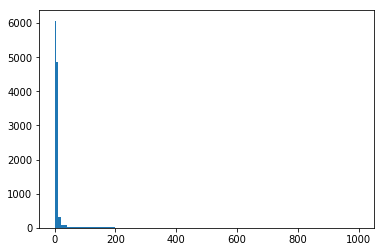

In [36]:
#this is a histogram of the average distribution of counts for the owner id.

plt.hist(scores.owner_id.value_counts(), bins=[0,1,5,10,20,40,80,200,1000] )

In [37]:
#Here we will begin to convert the amount of times amount of times an owner appears into a categorical variable

def cat_to_num(x):
    if x >= 100: 
        return 0
    if x >= 60: 
        return 1
    if x >= 40:
        return 2
    if x >= 20:
        return 3
    if x >= 10:
        return 4
    if x >= 5:
        return 5
    if x > 1:
        return 6
    if x == 1:
        return 7
    
scores['uniqueness'] = scores.freq.apply(cat_to_num)

In [38]:
print(scores.owner_name[scores.owner_name.str.contains("MCDONALD")])

118            MCDONALD'S CORPORATION
162      R & B SANCHEZ DBA MCDONALD'S
971                   MCDONALD'S CORP
1810     R & B SANCHEZ DBA MCDONALD'S
2128           MCDONALD'S CORPORATION
2282           MCDONALD'S CORPORATION
3301     R & B SANCHEZ DBA MCDONALD'S
3337           MCDONALD'S CORPORATION
3493           MCDONALD'S CORPORATION
4300           MCDONALD'S CORPORATION
5433           MCDONALD'S CORPORATION
7146     R & B SANCHEZ DBA MCDONALD'S
8395           MCDONALD'S CORPORATION
8758           MCDONALD'S CORPORATION
8940           MCDONALD'S CORPORATION
9172           MCDONALD'S CORPORATION
9300           MCDONALD'S CORPORATION
9692     R & B SANCHEZ DBA MCDONALD'S
9884     R & B SANCHEZ DBA MCDONALD'S
10044          MCDONALD'S CORPORATION
10268          MCDONALD'S CORPORATION
10953    R & B SANCHEZ DBA MCDONALD'S
11128                 MCDONALD'S CORP
11158          MCDONALD'S CORPORATION
11192    R & B SANCHEZ DBA MCDONALD'S
12067    R & B SANCHEZ DBA MCDONALD'S
12280       

In [39]:
#Now let's take a look at the differences between different program element description and see if there is any 
#significant differences between them.

description_violations = violations.groupby('pe_description').aggregate(np.mean)
description_scores = scores.groupby('pe_description').aggregate(np.mean)
print(description_scores)

                                                 score  service_code  \
pe_description                                                         
FOOD MKT RETAIL (2,000+ SF) HIGH RISK        91.938861      4.685092   
FOOD MKT RETAIL (2,000+ SF) LOW RISK         95.123580      2.988636   
FOOD MKT RETAIL (2,000+ SF) MODERATE RISK    94.728205      7.153846   
FOOD MKT RETAIL (25-1,999 SF) HIGH RISK      93.573434      3.159827   
FOOD MKT RETAIL (25-1,999 SF) LOW RISK       95.574088      2.094891   
FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK  93.909657      4.115265   
RESTAURANT (0-30) SEATS HIGH RISK            92.573571      7.232253   
RESTAURANT (0-30) SEATS LOW RISK             95.200938      3.679169   
RESTAURANT (0-30) SEATS MODERATE RISK        93.888662      6.325317   
RESTAURANT (151 + ) SEATS HIGH RISK          93.030751     14.258786   
RESTAURANT (151 + ) SEATS LOW RISK           95.770115      1.000000   
RESTAURANT (151 + ) SEATS MODERATE RISK      94.522267      7.47

In [48]:
types_grouped = scores['pe_description'].value_counts()

In [40]:
#Here we can see the distribution between all the different restaurant types

types_violations_grouped = violations['pe_description'].value_counts()
print(types_violations_grouped)

RESTAURANT (0-30) SEATS HIGH RISK              69820
RESTAURANT (31-60) SEATS HIGH RISK             50136
RESTAURANT (0-30) SEATS MODERATE RISK          38839
RESTAURANT (61-150) SEATS HIGH RISK            36937
FOOD MKT RETAIL (25-1,999 SF) LOW RISK         17890
FOOD MKT RETAIL (25-1,999 SF) HIGH RISK        12399
RESTAURANT (151 + ) SEATS HIGH RISK            12202
RESTAURANT (31-60) SEATS MODERATE RISK          7049
FOOD MKT RETAIL (2,000+ SF) HIGH RISK           6610
FOOD MKT RETAIL (2,000+ SF) LOW RISK            5057
RESTAURANT (0-30) SEATS LOW RISK                4921
RESTAURANT (61-150) SEATS MODERATE RISK         3715
FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK     2694
RESTAURANT (31-60) SEATS LOW RISK               1639
RESTAURANT (151 + ) SEATS MODERATE RISK          970
RESTAURANT (61-150) SEATS LOW RISK               886
FOOD MKT RETAIL (2,000+ SF) MODERATE RISK        769
RESTAURANT (151 + ) SEATS LOW RISK               268
Name: pe_description, dtype: int64


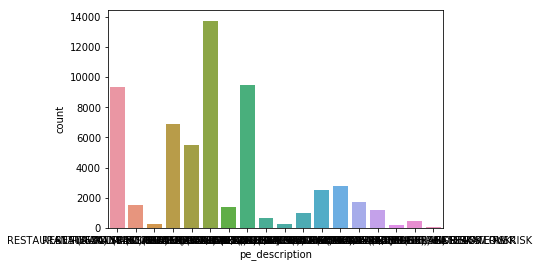

In [47]:
#Let's look at this in a graphic view.  As we can see that their are some
#groups that are highly concentrated and some that have very few.  

sns.countplot(x='pe_description', data=scores, orient= "v")

In [18]:
#Create the average health code violation per restaurant group

per_type = types_violations_grouped / types_grouped
per_type = per_type.sort_values(ascending=False)
print(per_type)

FOOD MKT RETAIL (2,000+ SF) HIGH RISK          5.536013
RESTAURANT (61-150) SEATS HIGH RISK            5.364072
RESTAURANT (31-60) SEATS HIGH RISK             5.296429
RESTAURANT (0-30) SEATS HIGH RISK              5.083364
RESTAURANT (151 + ) SEATS HIGH RISK            4.873003
FOOD MKT RETAIL (25-1,999 SF) HIGH RISK        4.463283
FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK    4.196262
RESTAURANT (0-30) SEATS MODERATE RISK          4.169959
RESTAURANT (31-60) SEATS MODERATE RISK         4.065167
FOOD MKT RETAIL (2,000+ SF) MODERATE RISK      3.943590
RESTAURANT (151 + ) SEATS MODERATE RISK        3.927126
RESTAURANT (61-150) SEATS MODERATE RISK        3.865765
FOOD MKT RETAIL (2,000+ SF) LOW RISK           3.591619
RESTAURANT (31-60) SEATS LOW RISK              3.393375
RESTAURANT (61-150) SEATS LOW RISK             3.343396
RESTAURANT (0-30) SEATS LOW RISK               3.296048
FOOD MKT RETAIL (25-1,999 SF) LOW RISK         3.264599
RESTAURANT (151 + ) SEATS LOW RISK             3

AxesSubplot(0.1,0.15;0.8x0.75)


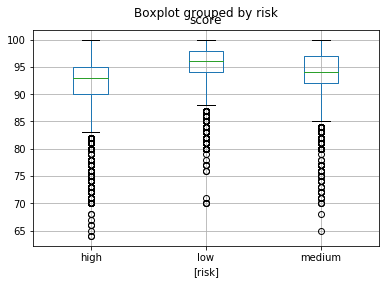

In [49]:
#Lets begin to investigate the distribution of Risk and what it means for our data

scores['high'] = scores['pe_description'].str.contains('HIGH')
scores['medium'] = scores['pe_description'].str.contains('MODERATE')
scores['low'] = scores['pe_description'].str.contains('LOW')
#print(scores[['low', 'pe_description', 'high', 'medium']])
scores['risk'] = scores['low'].apply(lambda x: 'low' if x else np.NaN)
scores['risk'][scores.high == True] = 'high'
scores['risk'][scores.medium == True] = 'medium'


print(scores[['score', 'risk']].boxplot(by='risk'))

It appears to me that all of the different risk ratings are assigned previously before the actuall inspection. 

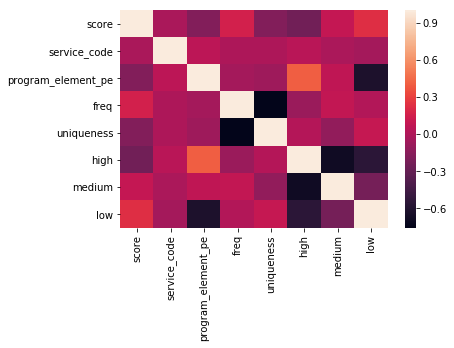

In [50]:
#Let's take a look at the correlation between our different variables.
corr_scores = scores.corr()

sns.heatmap(corr_scores)

In [29]:
#Now let's take a quick look at the columns we have been able to generate.

scores.columns


Index(['serial_number', 'activity_date', 'facility_name', 'score', 'grade',
       'service_code', 'service_description', 'employee_id',
       'facility_address', 'facility_city', 'facility_id', 'facility_state',
       'facility_zip', 'owner_id', 'owner_name', 'pe_description',
       'program_element_pe', 'program_name', 'program_status', 'record_id',
       'high', 'medium', 'low', 'risk', 'freq', 'uniqueness'],
      dtype='object')

In [63]:
#Create wanted data frame with parameters
X = scores[['service_code', 'facility_city', 'facility_zip', 'pe_description', 'program_status', 'risk', 'freq', 'uniqueness']]
y = scores[['score']]


In [64]:
#get_dummies for certain columns
X = pd.get_dummies(X, columns=['service_code', 'facility_city', 'facility_zip', 'pe_description', 'program_status', 'risk'])


In [65]:
#Create training and test for the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [33]:
#First let's create a regression model using the Random forest decision tree. 

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)
cross_val_score(rfr, X_train, y_train, cv=5)

array([0.16539393, 0.14183221, 0.16733931, 0.15700635, 0.12965472])

In [74]:
# Let's take a look and see if we can boost our model to try and save these terrible results
#We see a minor increase in predictability
params = {'n_estimators': 500, 
         'max_depth': 3,
         'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv=5)

array([0.16685386, 0.1683267 , 0.17540772, 0.17067404, 0.17654952])

Well that didn't work out very well.  Let's investigate how the model does as a categorizer when looking at the data.  

In [35]:
scores.grade.unique()

array(['A', 'B', 'C', ' '], dtype=object)

Now that we have investigated the unique types of grades we can convert them to something we can run a model on

In [54]:
def letter_to_num(x):
    if x =='A':
        return 1 
    if x =='B':
        return 2
    if x == 'C':
        return 3
    if x == ' ':
        return 3


scores['letter_num'] = scores.grade.apply(letter_to_num)  



In [55]:
def letter_to_num2(x):
    if x =='A':
        return 1 
    if x =='B':
        return 2
    if x == 'C':
        return 2
    if x == ' ':
        return 2


scores['two_grades'] = scores.grade.apply(letter_to_num2)  



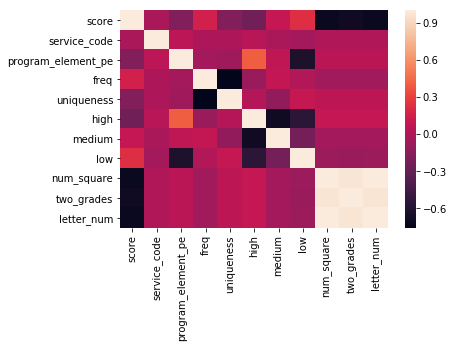

In [56]:
#Let's see if the correlations are any different now that we only have three different
#variables we are looking at

correlation_mat = scores.corr()
sns.heatmap(correlation_mat)

(array([54904.,     0.,     0.,     0.,     0.,  3676.,     0.,     0.,
            0.,   292.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

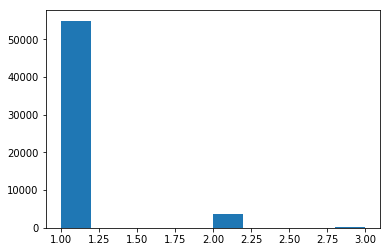

In [57]:
plt.hist(scores.letter_num)

In [66]:
scores.num_square.value_counts()

1    54904
2     3676
3      292
Name: num_square, dtype: int64

In [67]:
#how would it do against all As, or Bs, or Cs
#Group into either all A or not A
#bernouli naive bayes:
#kNN

In [68]:
y2 = scores['num_square']
y3 = scores['two_grades']

In [69]:
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.4)

X_train, X_test, y_train3, y_test3 = train_test_split(X, y3, test_size=0.4)

In [70]:
# on the classifier first of all groups
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train2)
cross_val_score(rfc, X_train, y_train2, cv=5)

NameError: name 'ensemble' is not defined

In [61]:
#crosstab to see if we are generating errors and how we are doing it:
from sklearn.metrics import confusion_matrix
y_pred = rfc.fit(X_train, y_train2).predict(X_train)

confusion_matrix(y_train2, y_pred)

array([[32865,   100,     9],
       [ 1966,   213,     1],
       [  159,     3,     7]], dtype=int64)

In [62]:
# either A or not A
rfc.fit(X_train, y_train3)
cross_val_score(rfc, X_train, y_train3, cv=5)

array([0.92696391, 0.92569002, 0.92512385, 0.924547  , 0.92652888])

In [63]:
#now lets take a look at the kind of errors we are generating to see how well
#it is performing
y_pred2 = rfc.fit(X_train, y_train3).predict(X_train)

confusion_matrix(y_train3, y_pred2)

array([[32750,   173],
       [ 1928,   472]], dtype=int64)

In [64]:
#Now lets take a look at this through the lense of the bernoulli.
#Errors seem to be about the same between bernoulli and random forest classifier

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train3)
cross_val_score(bnb, X_train, y_train3, cv=5)

array([0.92229299, 0.92866242, 0.92540694, 0.92652888, 0.92483012])

In [65]:
#It appears that the system mislabels more than if it were to just assume all were
#just labeled as As

y_pred3 = bnb.predict(X_train)

print("Number of mislabeled points out of a total {} points : {}".format(
    X_train.shape[0],
    (y_train3 != y_pred).sum()
))

Number of mislabeled points out of a total 35323 points : 2687


In [66]:
confusion_matrix(y_train3, y_pred3)

array([[32680,   243],
       [ 2273,   127]], dtype=int64)